<a href="https://colab.research.google.com/github/Bob3110/CodeAlpha-projects/blob/main/Task_2_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
!pip install yfinance pandas numpy matplotlib seaborn keras tensorflow

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


[*********************100%%**********************]  3 of 3 completed


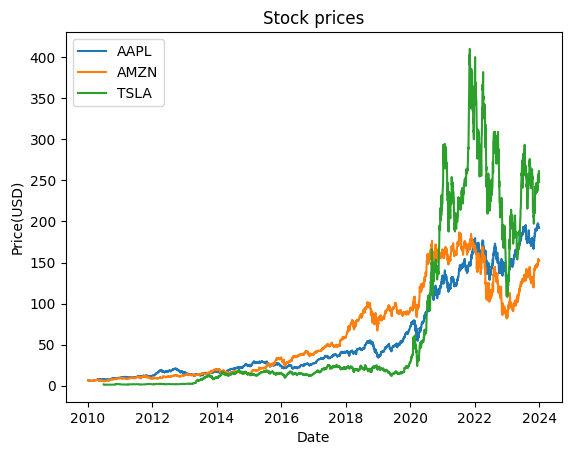

In [3]:
symbols = ['AAPL','AMZN','TSLA']
start_date = '2010-01-01'
end_date = '2024-01-01'

df = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

for symbol in symbols:
  plt.plot(df[symbol],label=symbol)
plt.title('Stock prices')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.show()

# **Retrieving data for Amazon(AMZN) stock**

In [4]:
stock_data = ['AMZN']
start_date = '2010-01-01'
end_date = '2024-01-01'

data= yf.download(stock_data, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


# **Visualizations**

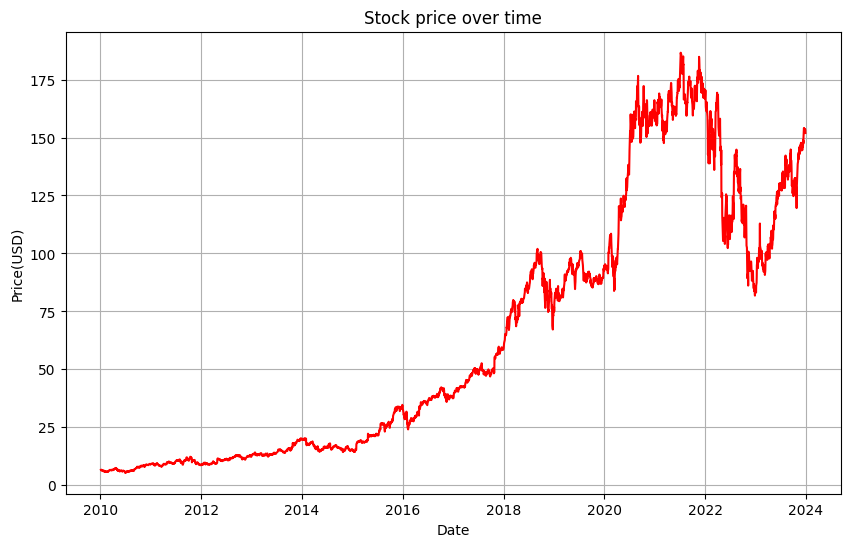

In [6]:
#Lineplot to visualize the trend of the stock prices over time
plt.figure(figsize=(10,6))
sns.lineplot(data['Close'],color='red')
plt.title('Stock price over time')
plt.xlabel('Date')
plt.ylabel("Price(USD)")
plt.grid(True)
plt.show()

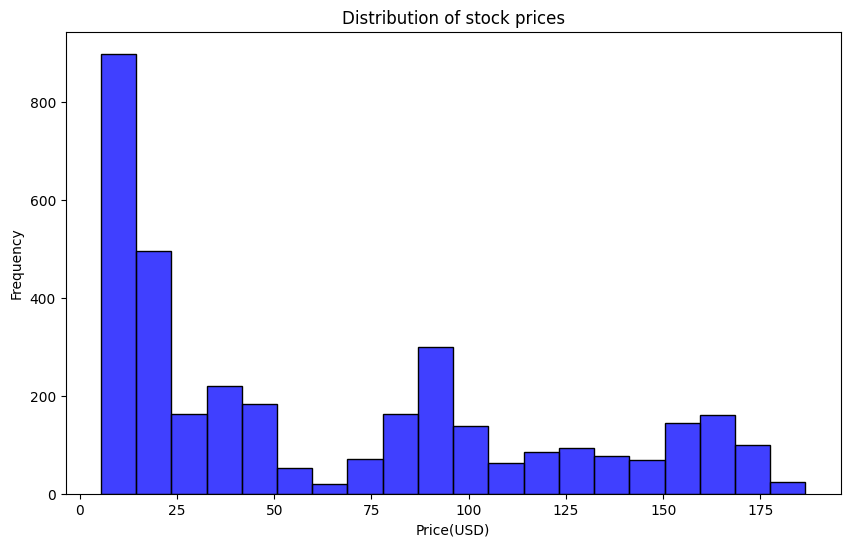

In [7]:
#Histogram to visualize the distribution of stock prices
plt.figure(figsize=(10,6))
sns.histplot(data['Close'],bins=20,color='blue',edgecolor='black')
plt.title('Distribution of stock prices')
plt.xlabel('Price(USD)')
plt.ylabel('Frequency')
plt.show()

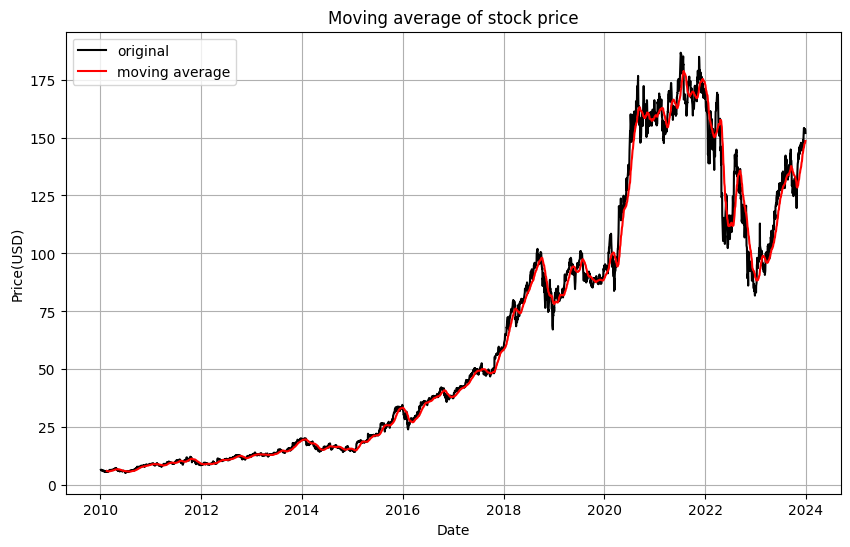

In [8]:
#Moving average to visualize the moving average of stock prices over a certain period
window_size=30
plt.figure(figsize=(10,6))
plt.plot(data['Close'],color='black',label='original')
plt.plot(data['Close'].rolling(window=window_size).mean(),color='red',label='moving average')
plt.title('Moving average of stock price')
plt.xlabel('Date')
plt.ylabel('Price(USD)')
plt.legend()
plt.grid(True)
plt.show()

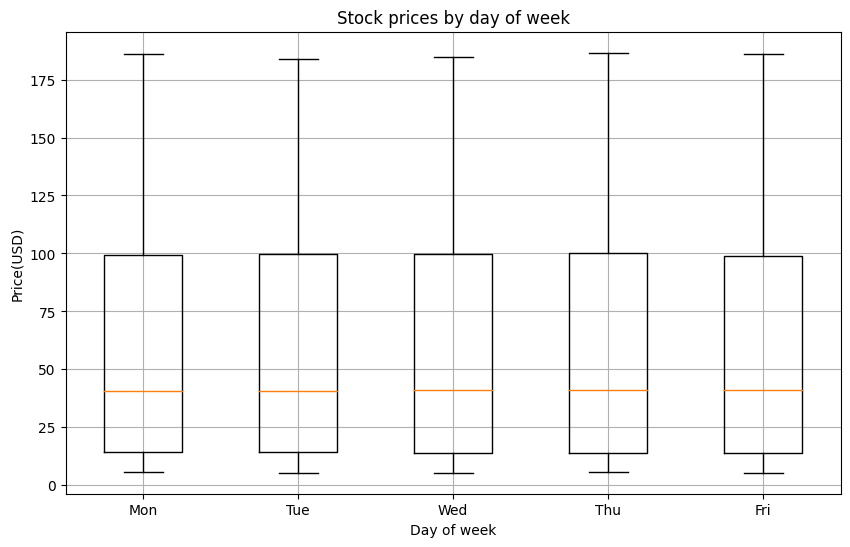

In [9]:
#Boxplot to visualize the distribution of stock prices over different time periods
data['Day_of_Week']=data.index.dayofweek
plt.figure(figsize=(10,6))
plt.boxplot([data[data['Day_of_Week'] == i]['Close'] for i in range(5)],labels=['Mon','Tue','Wed','Thu','Fri'])
plt.title('Stock prices by day of week')
plt.xlabel('Day of week')
plt.ylabel('Price(USD)')
plt.grid(True)
plt.show()

# **Data pre-proccessing**

In [10]:
dataset=data.values

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

training_data_len= int(np.ceil(0.8*len(dataset)))
train_data=scaled_data[0:training_data_len,:]
test_data=scaled_data[training_data_len-45:,:]

# **Create training dataset**

In [11]:
def create_dataset(data,time_step):
    x_data,y_data=[],[]
    for i in range(len(data)-time_step-1):
      x_data.append(data[i:(i+time_step),0])
      y_data.append(data[i+time_step,0])
    return np.array(x_data),np.array(y_data)
time_step=45
x_train,y_train=create_dataset(train_data,time_step)
x_test,y_test=create_dataset(test_data,time_step)

x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

# **Create the LSTM model**

In [12]:
model=Sequential()
model.add(LSTM(units=100,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

adam=Adam(learning_rate=0.001)

model.compile(optimizer=adam ,loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 100)           40800     
                                                                 
 dropout (Dropout)           (None, 45, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 45, 100)           80400     
                                                                 
 dropout_1 (Dropout)         (None, 45, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

# **Train the LSTM model using the training set**

In [13]:
history=model.fit(x_train,y_train,batch_size=128,epochs=50,validation_data=(x_test,y_test),verbose=1)

Epoch 1/50
22/22 [==============================] - 15s 363ms/step - loss: 0.0173 - val_loss: 0.0060
Epoch 2/50
22/22 [==============================] - 8s 345ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 3/50
22/22 [==============================] - 7s 342ms/step - loss: 9.5453e-04 - val_loss: 0.0022
Epoch 4/50
22/22 [==============================] - 7s 301ms/step - loss: 8.3679e-04 - val_loss: 0.0024
Epoch 5/50
22/22 [==============================] - 8s 344ms/step - loss: 8.5993e-04 - val_loss: 0.0022
Epoch 6/50
22/22 [==============================] - 7s 298ms/step - loss: 8.0829e-04 - val_loss: 0.0021
Epoch 7/50
22/22 [==============================] - 8s 345ms/step - loss: 7.7912e-04 - val_loss: 0.0032
Epoch 8/50
22/22 [==============================] - 7s 302ms/step - loss: 8.3439e-04 - val_loss: 0.0021
Epoch 9/50
22/22 [==============================] - 8s 347ms/step - loss: 7.0986e-04 - val_loss: 0.0021
Epoch 10/50
22/22 [==============================] - 8s 351ms/step - lo

In [14]:
loss=model.evaluate(x_test,y_test)
print("Test loss:",loss)

22/22 [==============================] - 1s 39ms/step - loss: 0.0015
Test loss: 0.001459393184632063


In [15]:
predictions=model.predict(x_test)

mae=mean_absolute_error(y_test,predictions)
r2=r2_score(y_test,predictions)

print("Mean absolute error:",mae)
print("R2:",r2)

22/22 [==============================] - 2s 34ms/step
Mean absolute error: 0.02880057798298812
R2: 0.9375084528244766


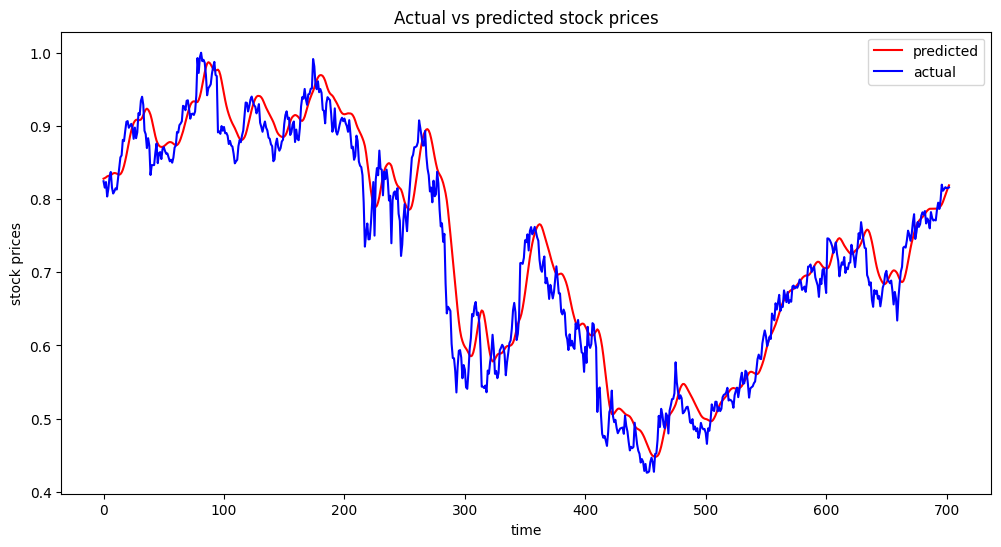

In [16]:
plt.figure(figsize=(12,6))
plt.plot(predictions,label='predicted',color='red')
plt.plot(y_test,label='actual',color='blue')
plt.title("Actual vs predicted stock prices")
plt.xlabel("time")
plt.ylabel("stock prices")
plt.legend()
plt.show()

In [17]:
results_df = pd.DataFrame({'Actual': y_test.reshape(-1), 'Predicted': predictions.reshape(-1)})
print(results_df)

       Actual  Predicted
0    0.824349   0.827921
1    0.815622   0.828656
2    0.823258   0.829684
3    0.803530   0.830986
4    0.814146   0.831716
..        ...        ...
698  0.813637   0.800812
699  0.816221   0.805576
700  0.815067   0.810374
701  0.815067   0.814860
702  0.815946   0.818800

[703 rows x 2 columns]
